<a href="https://colab.research.google.com/github/Leonardo-Dias-Up/Colab/blob/main/DataViva_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **IMPORTAÇÃO DAS BIBLIOTECAS**

In [ ]:
!pip install geopandas
!pip install pysal
!pip install cartopy
!pip install --upgrade matplotlib
!pip install windrose
!pip install linearmodels
!pip install ipeadatapy
!!pip install python-bcb
!pip install factor_analyzer
!pip install sgs
!apt-get install -y fonts-liberation
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files

import pandas as pd
import geopandas as gpd
import numpy as np

from libpysal import weights
import matplotlib.pyplot as plt
import seaborn as sns
import splot
from pysal.explore import esda
from pysal.model import spreg
import pysal as ps
import scipy.sparse as sp
import statsmodels.api as sm
from libpysal.weights import Queen, Rook, KNN, DistanceBand
import pysal.lib as lps
from esda.moran import Moran
import libpysal
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from PIL import Image
from linearmodels.panel import RandomEffects, PanelOLS
from scipy.stats import f_oneway
from scipy.stats import pearsonr, norm
from matplotlib.gridspec import GridSpec
import networkx as nx

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


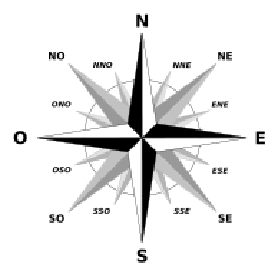

In [3]:
# Melhora a resolução da imagem
img = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/TCC/windrose.png')
dpi = 70
height, width, nbands = img.shape
figsize = width / float(dpi), height / float(dpi)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img, interpolation='nearest')

> **IMPORTAÇÃO DAS BASES DE DADOS TRATADAS VIA GOOGLE CLOUD PLATAFORM - BIG QUERY**

In [4]:
# Configurar o cliente do BigQuery
credentials = service_account.Credentials.from_service_account_file(r"/content/drive/MyDrive/Colab Notebooks/TCC/bigquey-chave.json")
project_id = 'rais-359504'
client = bigquery.Client(credentials=credentials, project=project_id)

In [5]:
# Bases
geo_mun = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/DataViva/BR_Municipios_2022.shp')
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataViva/RAIS_MG_2010_2020.csv', sep=';', encoding='UTF-8')
cnae_divisoes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataViva/cnae_divisão.csv', sep=';', encoding='UTF-8')

# Para float
geo_mun.CD_MUN = geo_mun.CD_MUN.astype(float)
base.id_municipio = base.id_municipio.astype(float)

# Para o merge
base.cnae_divisao = base.cnae_divisao.astype(int)

# Para o merge
geo_mun = geo_mun.rename(columns={'CD_MUN':'id_municipio'})

# Para o merge
cnae_divisoes = cnae_divisoes.rename(columns={'Divisões':'cnae_divisao'})

In [6]:
base.head()

,ano,id_municipio,cnae_divisao,massa_salarial_dezembro,num_emp
0,2010,3118601.0,27,10517813.06,4552
1,2010,3151800.0,7,2451832.99,1235
2,2010,3131703.0,7,30517730.17,11625
3,2010,3106200.0,78,14598736.03,19274
4,2010,3118601.0,78,4044620.92,5501


In [7]:
geo_mun.head()

,id_municipio,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015.0,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023.0,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031.0,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049.0,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056.0,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1..."


In [8]:
cnae_divisoes.head()

,Seção,cnae_divisao,Denominação
0,A,01 .. 03,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
1,B,05 .. 09,INDÚSTRIAS EXTRATIVAS
2,C,10 .. 33,INDÚSTRIAS DE TRANSFORMAÇÃO
3,D,35 .. 35,ELETRICIDADE E GÁS
4,E,36 .. 39,"ÁGUA, ESGOTO, ATIVIDADES DE GESTÃO DE RESÍDUOS..."


In [9]:
# Função para expandir os intervalos
def expandir_intervalo(row):
    inicio, fim = row['cnae_divisao'].split(' .. ')
    intervalo = list(range(int(inicio), int(fim)+1))
    return pd.DataFrame({'Seção': row['Seção'], 'cnae_divisao': intervalo, 'Denominação': row['Denominação']})

# Aplicar a função para expandir os intervalos para todos os números de 1 a 99
cnae_divisoes_expandido = pd.concat([expandir_intervalo(row) for _, row in cnae_divisoes.iterrows()], ignore_index=True)

# Converter a coluna 'cnae_divisao' para o tipo int
cnae_divisoes_expandido['cnae_divisao'] = cnae_divisoes_expandido['cnae_divisao'].astype(int)

# Exibir o resultado
cnae_divisoes_expandido.head()

,Seção,cnae_divisao,Denominação
0,A,1,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
1,A,2,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
2,A,3,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
3,B,5,INDÚSTRIAS EXTRATIVAS
4,B,6,INDÚSTRIAS EXTRATIVAS


In [10]:
# Full base
df = pd.merge(base, cnae_divisoes_expandido, on='cnae_divisao', how='left') \
                      .merge(geo_mun, on='id_municipio', how='left')

df.head()

,ano,id_municipio,cnae_divisao,massa_salarial_dezembro,num_emp,Seção,Denominação,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,2010,3118601.0,27,10517813.06,4552,C,INDÚSTRIAS DE TRANSFORMAÇÃO,Contagem,MG,194.746,"POLYGON ((-44.04721 -19.97373, -44.04728 -19.9..."
1,2010,3151800.0,7,2451832.99,1235,B,INDÚSTRIAS EXTRATIVAS,Poços de Caldas,MG,546.958,"POLYGON ((-46.48069 -21.70049, -46.48045 -21.7..."
2,2010,3131703.0,7,30517730.17,11625,B,INDÚSTRIAS EXTRATIVAS,Itabira,MG,1253.704,"POLYGON ((-43.28319 -19.76310, -43.28322 -19.7..."
3,2010,3106200.0,78,14598736.03,19274,N,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,Belo Horizonte,MG,331.354,"POLYGON ((-43.86960 -19.92388, -43.86960 -19.9..."
4,2010,3118601.0,78,4044620.92,5501,N,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,Contagem,MG,194.746,"POLYGON ((-44.04721 -19.97373, -44.04728 -19.9..."


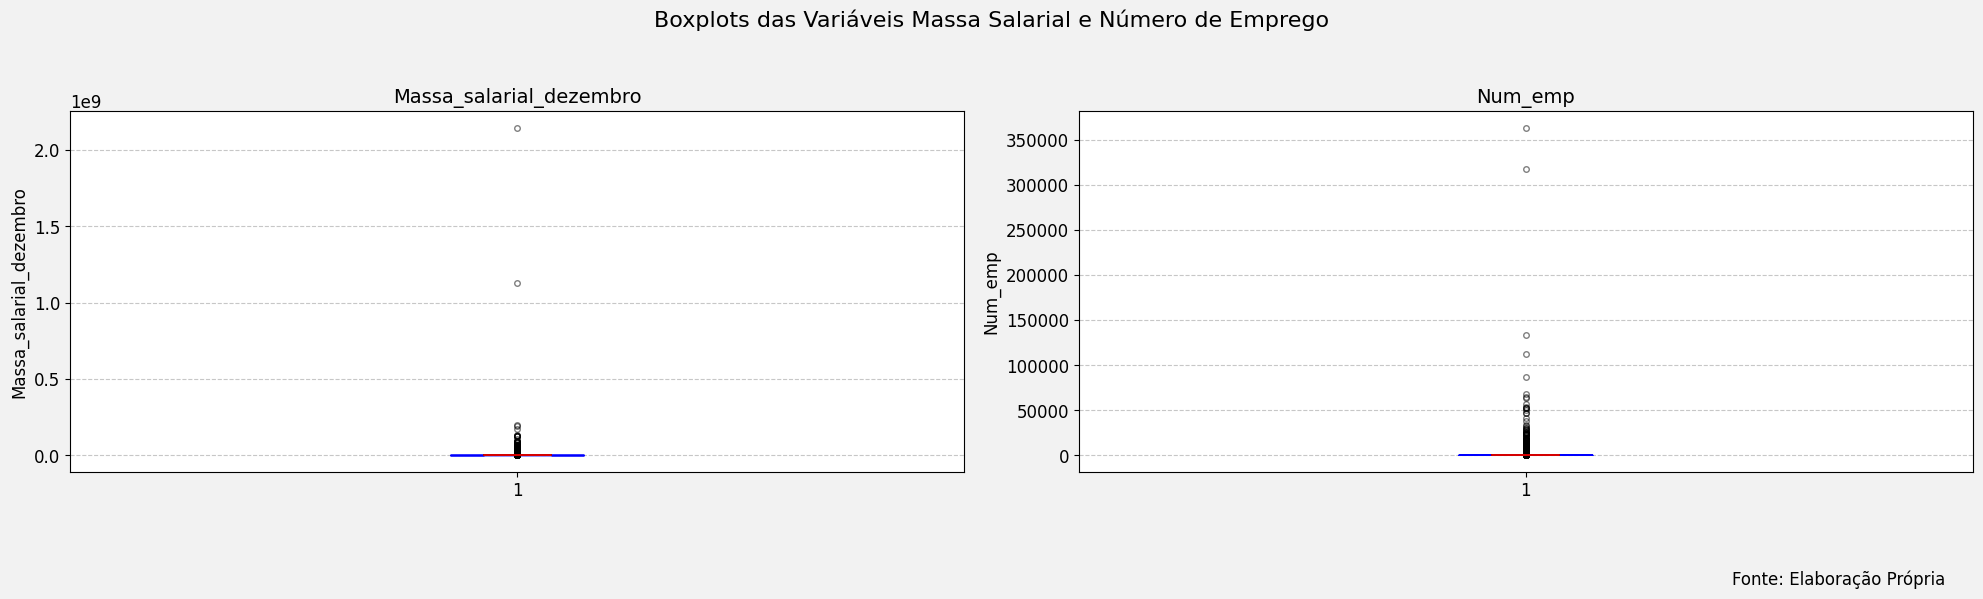

In [115]:
# Selecionar as variáveis numéricas do dataframe
numerical_cols = ['massa_salarial_dezembro', 'num_emp']

# Criar os boxplots para cada variável
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(20, 7))

for i, col in enumerate(numerical_cols):
    bp = axes[i].boxplot(df[col], notch=True, patch_artist=True)
    axes[i].set_title(col.capitalize(), fontsize=14)
    axes[i].set_ylabel(col.capitalize(), fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_edgecolor('blue')
    for whisker in bp['whiskers']:
        whisker.set(color='black', linewidth=1.2, linestyle='-')
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1.2)
    for median in bp['medians']:
        median.set(color='red', linewidth=1.2)
    for flier in bp['fliers']:
        flier.set(marker='o', color='black', alpha=0.5, markersize=4)

fig.suptitle('Boxplots das Variáveis Massa Salarial e Número de Empregos', fontsize=16)
fig.set_facecolor('#f2f2f2')  # Definir cor de fundo
plt.rc('font', family='sans-serif', size=12)
plt.text(0.85, -.3, 'Fonte: Elaboração Própria', ha='center', va='center', transform=axes[-1].transAxes)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

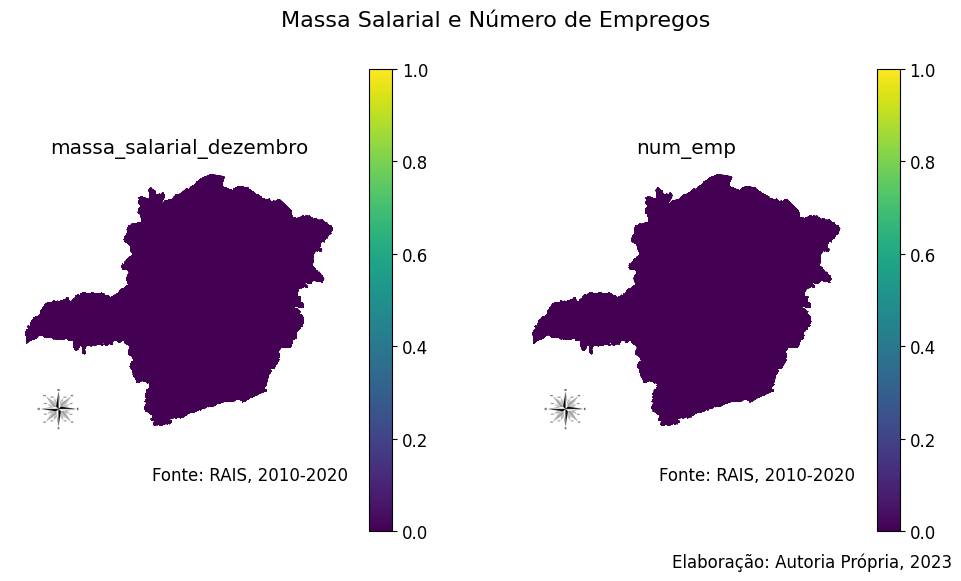

In [116]:
# Seleciona as colunas de interesse
columns = numerical_cols

data = df[columns]

# Normalizar os dados de 0 a 1
data_norm = (data - data.min()) / (data.max() - data.min())

# Criar um novo GeoDataFrame com os dados normalizados e as geometrias dos municípios
data_norm_df = gpd.GeoDataFrame(pd.concat([data_norm, df['geometry']], axis=1))

# Plotar os mapas para cada coluna 4 x 4
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
n_graficos = len(columns) # Selecionar o número de gráficos gerados
axs = axs.flat[:n_graficos] # Seleciona as primeiras 13 subplots

for ax, col in zip(axs.flat, columns):
    data_norm_df.plot(column=col, ax=ax, legend=True, cmap='viridis')
    ax.set_title(col)
    ax.set_facecolor('#f2f2f2')
    ax.axis('off')
    ax.text(1.0, -0.15, 'Fonte: RAIS, 2010-2020', fontsize=12, ha='right', transform=ax.transAxes)
    axins2 = ax.inset_axes([0.065, 0.03, 0.15, 0.15], transform=ax.transAxes)
    axins2.set_aspect('equal')
    axins2.axis('off')
    axins2.imshow(img)

# Espaçamento entre os gráficos
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Adiciona o título
plt.suptitle('Massa Salarial e Número de Empregos', fontsize=16, x=0.53)

# Adiciona a fonte do gráfico geral
fig.text(0.91, 0.05, 'Elaboração: Autoria Própria, 2023', fontsize=12, ha='right')

# Exibe a plotagem
plt.show()

>Principais Atividades por Emprego e Massa Salarial

In [13]:
# Filtrar os dados para os anos de 2010 e 2020
df_2010 = df[df['ano'] == 2010]
df_2020 = df[df['ano'] == 2020]

# Agrupar os dados por cnae_divisao e calcular a soma do número de empregados e da massa salarial para cada cnae_divisao
emprego_2010 = df_2010.groupby('cnae_divisao').agg({'num_emp': 'sum', 'NM_MUN': 'first', 'id_municipio': 'first', 'Denominação': 'first'}).reset_index()
emprego_2020 = df_2020.groupby('cnae_divisao').agg({'num_emp': 'sum', 'NM_MUN': 'first', 'id_municipio': 'first', 'Denominação': 'first'}).reset_index()

# Ordenar os dados em ordem decrescente com base nos valores de emprego para identificar as principais atividades econômicas em termos de emprego
principais_emprego_2010 = emprego_2010.sort_values('num_emp', ascending=False)
principais_emprego_2020 = emprego_2020.sort_values('num_emp', ascending=False)

In [14]:
# Agrupar os dados por cnae_divisao e calcular a soma da massa salarial para cada cnae_divisao
massa_salarial_2010 = df_2010.groupby('cnae_divisao').agg({'massa_salarial_dezembro': 'sum', 'NM_MUN': 'first', 'id_municipio': 'first', 'Denominação': 'first'}).reset_index()
massa_salarial_2020 = df_2020.groupby('cnae_divisao').agg({'massa_salarial_dezembro': 'sum', 'NM_MUN': 'first', 'id_municipio': 'first', 'Denominação': 'first'}).reset_index()

# Ordenar os dados em ordem decrescente com base nos valores de massa salarial para identificar as principais atividades econômicas em termos de massa salarial
principais_massa_salarial_2010 = massa_salarial_2010.sort_values('massa_salarial_dezembro', ascending=False)
principais_massa_salarial_2020 = massa_salarial_2020.sort_values('massa_salarial_dezembro', ascending=False)

In [15]:
print("Principais atividades econômicas em termos de emprego em 2010:")
principais_emprego_2010.head()

Principais atividades econômicas em termos de emprego em 2010:


,cnae_divisao,num_emp,NM_MUN,id_municipio,Denominação
73,84,886825,São Miguel do Anta,3163805.0,"ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
42,47,644710,Belo Horizonte,3106200.0,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...
0,1,230286,Cambuquira,3110707.0,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
43,49,175031,Contagem,3118601.0,"TRANSPORTE, ARMAZENAGEM E CORREIO"
75,86,160018,Belo Horizonte,3106200.0,SAÚDE HUMANA E SERVIÇOS SOCIAIS


In [16]:
print("Principais atividades econômicas em termos de emprego em 2020:")
principais_emprego_2020.head()

Principais atividades econômicas em termos de emprego em 2020:


,cnae_divisao,num_emp,NM_MUN,id_municipio,Denominação
73,84,847659,Barbacena,3105608.0,"ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
42,47,672080,Conceição dos Ouros,3117801.0,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...
75,86,231167,Juiz de Fora,3136702.0,SAÚDE HUMANA E SERVIÇOS SOCIAIS
0,1,223740,Sacramento,3156908.0,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES..."
43,49,189464,Indianópolis,3130705.0,"TRANSPORTE, ARMAZENAGEM E CORREIO"


In [17]:
print("Principais atividades econômicas em termos de emprego em 2010:")
principais_massa_salarial_2010.head()

Principais atividades econômicas em termos de emprego em 2010:


,cnae_divisao,massa_salarial_dezembro,NM_MUN,id_municipio,Denominação
73,84,1.858852e+09,São Miguel do Anta,3163805.0,"ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
42,47,5.194118e+08,Belo Horizonte,3106200.0,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...
74,85,3.657725e+08,Pouso Alegre,3152501.0,EDUCAÇÃO
43,49,2.006266e+08,Contagem,3118601.0,"TRANSPORTE, ARMAZENAGEM E CORREIO"
75,86,1.999942e+08,Belo Horizonte,3106200.0,SAÚDE HUMANA E SERVIÇOS SOCIAIS


In [18]:
print("Principais atividades econômicas em termos de emprego em 2020:")
principais_massa_salarial_2020.head()

Principais atividades econômicas em termos de emprego em 2020:


,cnae_divisao,massa_salarial_dezembro,NM_MUN,id_municipio,Denominação
73,84,3.732669e+09,Barbacena,3105608.0,"ADMINISTRAÇÃO PÚBLICA, DEFESA E SEGURIDADE SOCIAL"
42,47,1.002861e+09,Conceição dos Ouros,3117801.0,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...
74,85,5.672104e+08,Caratinga,3113404.0,EDUCAÇÃO
75,86,5.555073e+08,Juiz de Fora,3136702.0,SAÚDE HUMANA E SERVIÇOS SOCIAIS
43,49,3.902305e+08,Indianópolis,3130705.0,"TRANSPORTE, ARMAZENAGEM E CORREIO"


> Principais Localidades por Emprego e Massa Salarial para o setor Industrial

In [19]:
# Filtrar os dados para os anos de 2010 e 2020 e para os CNAE's referente as industrias
df_2010 = df[(df['ano'] == 2010) & (df['cnae_divisao'].between(5, 33))]
df_2020 = df[(df['ano'] == 2020) & (df['cnae_divisao'].between(5, 33))]

In [20]:
# Agrupar os dados por município e calcular a soma do número de empregados e da massa salarial para cada ano
emprego_2010 = df_2010.groupby('NM_MUN').agg({'num_emp': 'sum'}).reset_index()
massa_salarial_2010 = df_2010.groupby('NM_MUN').agg({'massa_salarial_dezembro': 'sum'}).reset_index()

emprego_2020 = df_2020.groupby('NM_MUN').agg({'num_emp': 'sum'}).reset_index()
massa_salarial_2020 = df_2020.groupby('NM_MUN').agg({'massa_salarial_dezembro': 'sum'}).reset_index()

# Ordenar os dados em ordem decrescente com base nos valores de emprego e massa salarial para identificar as principais localidades
principais_localidades_emprego_2010 = emprego_2010.sort_values('num_emp', ascending=False)
principais_localidades_massa_salarial_2010 = massa_salarial_2010.sort_values('massa_salarial_dezembro', ascending=False)

principais_localidades_emprego_2020 = emprego_2020.sort_values('num_emp', ascending=False)
principais_localidades_massa_salarial_2020 = massa_salarial_2020.sort_values('massa_salarial_dezembro', ascending=False)

In [21]:
print("Principais localidades em termos de emprego em 2010:")
principais_localidades_emprego_2010.head()

Principais localidades em termos de emprego em 2010:


,NM_MUN,num_emp
59,Belo Horizonte,68963
184,Contagem,51986
65,Betim,51531
741,Uberlândia,26143
322,Ipatinga,25629


In [22]:
print("Principais localidades em termos de emprego em 2020:")
principais_localidades_emprego_2020.head()

Principais localidades em termos de emprego em 2020:


,NM_MUN,num_emp
187,Contagem,44367
59,Belo Horizonte,43952
64,Betim,39640
765,Uberlândia,26365
677,Sete Lagoas,18224


In [23]:
print("Principais localidades em termos de massa salarial em 2010:")
principais_localidades_massa_salarial_2010.head()

Principais localidades em termos de massa salarial em 2010:


,NM_MUN,massa_salarial_dezembro
59,Belo Horizonte,1.455367e+08
65,Betim,1.223423e+08
184,Contagem,9.167332e+07
322,Ipatinga,6.000568e+07
741,Uberlândia,3.431387e+07


In [24]:
print("Principais localidades em termos de massa salarial em 2020:")
principais_localidades_massa_salarial_2020.head()

Principais localidades em termos de massa salarial em 2020:


,NM_MUN,massa_salarial_dezembro
64,Betim,1.622379e+08
59,Belo Horizonte,1.441675e+08
187,Contagem,1.374935e+08
34,Araxá,9.895040e+07
486,Nova Lima,6.871593e+07


In [25]:
# Filtrar os dados para os municípios com mais empregos em 2010
top_cidades_emprego_2010 = principais_localidades_emprego_2010.head(5)['NM_MUN'].tolist()

# Filtrar os dados para os municípios com mais empregos em 2020
top_cidades_emprego_2020 = principais_localidades_emprego_2020.head(5)['NM_MUN'].tolist()

# Filtrar os dados para os CNAEs com mais empregos nas principais cidades em 2010
top_cnaes_2010 = df_2010[df_2010['NM_MUN'].isin(top_cidades_emprego_2010)].groupby(['NM_MUN', 'cnae_divisao', 'Denominação']).agg({'num_emp': 'sum'}).reset_index()
top_cnaes_2010 = top_cnaes_2010.sort_values(['NM_MUN', 'num_emp'], ascending=[True, False]).groupby('NM_MUN').head()

# Filtrar os dados para os CNAEs com mais empregos nas principais cidades em 2020
top_cnaes_2020 = df_2020[df_2020['NM_MUN'].isin(top_cidades_emprego_2020)].groupby(['NM_MUN', 'cnae_divisao', 'Denominação']).agg({'num_emp': 'sum'}).reset_index()
top_cnaes_2020 = top_cnaes_2020.sort_values(['NM_MUN', 'num_emp'], ascending=[True, False]).groupby('NM_MUN').head()

In [26]:
# Exibir os resultados
print("Detalhes das principais cidades em termos de emprego em 2010:")
for cidade in top_cidades_emprego_2010:
    print(f"\nCidade: {cidade}")
    print(top_cnaes_2010[top_cnaes_2010['NM_MUN'] == cidade][['cnae_divisao', 'Denominação', 'num_emp']])

Detalhes das principais cidades em termos de emprego em 2010:

Cidade: Belo Horizonte
    cnae_divisao                  Denominação  num_emp
8             14  INDÚSTRIAS DE TRANSFORMAÇÃO     7712
18            24  INDÚSTRIAS DE TRANSFORMAÇÃO     7640
5             10  INDÚSTRIAS DE TRANSFORMAÇÃO     7274
19            25  INDÚSTRIAS DE TRANSFORMAÇÃO     5680
23            29  INDÚSTRIAS DE TRANSFORMAÇÃO     4279

Cidade: Contagem
    cnae_divisao                  Denominação  num_emp
55            10  INDÚSTRIAS DE TRANSFORMAÇÃO     7884
70            25  INDÚSTRIAS DE TRANSFORMAÇÃO     6211
74            29  INDÚSTRIAS DE TRANSFORMAÇÃO     5354
72            27  INDÚSTRIAS DE TRANSFORMAÇÃO     4552
69            24  INDÚSTRIAS DE TRANSFORMAÇÃO     4420

Cidade: Betim
    cnae_divisao                  Denominação  num_emp
48            29  INDÚSTRIAS DE TRANSFORMAÇÃO    20441
43            24  INDÚSTRIAS DE TRANSFORMAÇÃO     6875
52            33  INDÚSTRIAS DE TRANSFORMAÇÃO     4254
4

In [27]:
# Exibir os resultados
print("Detalhes das principais cidades em termos de emprego em 2020:")
for cidade in top_cidades_emprego_2020:
    print(f"\nCidade: {cidade}")
    print(top_cnaes_2020[top_cnaes_2020['NM_MUN'] == cidade][['cnae_divisao', 'Denominação', 'num_emp']])

Detalhes das principais cidades em termos de emprego em 2020:

Cidade: Contagem
    cnae_divisao                  Denominação  num_emp
55            10  INDÚSTRIAS DE TRANSFORMAÇÃO    10896
71            27  INDÚSTRIAS DE TRANSFORMAÇÃO     4626
69            25  INDÚSTRIAS DE TRANSFORMAÇÃO     3997
72            28  INDÚSTRIAS DE TRANSFORMAÇÃO     3639
73            29  INDÚSTRIAS DE TRANSFORMAÇÃO     3543

Cidade: Belo Horizonte
    cnae_divisao                  Denominação  num_emp
5             10  INDÚSTRIAS DE TRANSFORMAÇÃO     9351
19            24  INDÚSTRIAS DE TRANSFORMAÇÃO     4546
9             14  INDÚSTRIAS DE TRANSFORMAÇÃO     3400
27            32  INDÚSTRIAS DE TRANSFORMAÇÃO     3114
20            25  INDÚSTRIAS DE TRANSFORMAÇÃO     2874

Cidade: Betim
    cnae_divisao                  Denominação  num_emp
49            29  INDÚSTRIAS DE TRANSFORMAÇÃO    16145
44            24  INDÚSTRIAS DE TRANSFORMAÇÃO     6123
45            25  INDÚSTRIAS DE TRANSFORMAÇÃO     2726
3

> Setor Especializado em Minas Gerais - Construção

In [50]:
# Filtrar os dados para os anos de 2010 e 2020 para o setor de Construção
df_2010 = df[(df['ano'] == 2010)]
df_2020 = df[(df['ano'] == 2020)]

df_2010_construcao = df[(df['ano'] == 2010) & (df['cnae_divisao'].between(41, 43))]
df_2020_construcao = df[(df['ano'] == 2020) & (df['cnae_divisao'].between(41, 43))]

In [89]:
# Calcular o total de empregos na atividade de Construção em 2010 por município
empregos_construcao_regional_2010 = df_2010_construcao.groupby('id_municipio')['num_emp'].sum()

# Calcular o total de empregos na atividade de Construção em 2010 para a nação (somatório das regiões)
empregos_construcao_nacao_2010 = empregos_construcao_regional_2010.sum()

# Calcular o total de empregos em todos os setores em 2010 por município
empregos_total_regional_2010 = df_2010.groupby('id_municipio')['num_emp'].sum()

# Calcular o total de empregos em todos os setores em 2010 para a nação (somatório das regiões)
empregos_total_nacao_2010 = empregos_total_regional_2010.sum()

# Calcular o QL (Índice de Quociente Locacional) para o setor de Construção em 2010
ql_construcao_2010 = (empregos_construcao_regional_2010 / empregos_construcao_nacao_2010) / (empregos_total_regional_2010 / empregos_total_nacao_2010)

# Criar DataFrame com a coluna "ql"
df_ql_construcao_2010 = pd.DataFrame({'ql': ql_construcao_2010})

# Exibir o DataFrame resultante
df_ql_construcao_2010 = df_ql_construcao_2010.dropna()

# Realizar o merge com o DataFrame Geo
df_ql_construcao_2010 = df_ql_construcao_2010.merge(geo_mun, on='id_municipio', how='left')

# Exibir o DataFrame resultante
df_ql_construcao_2010.head()

,id_municipio,ql,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3100104.0,0.096023,Abadia dos Dourados,MG,880.461,"POLYGON ((-47.45335 -18.46925, -47.45341 -18.4..."
1,3100203.0,0.547014,Abaeté,MG,1817.067,"POLYGON ((-45.50026 -19.22585, -45.50024 -19.2..."
2,3100302.0,2.008114,Abre Campo,MG,470.551,"POLYGON ((-42.42074 -20.39718, -42.42076 -20.3..."
3,3100401.0,0.099747,Acaiaca,MG,101.886,"POLYGON ((-43.12231 -20.43351, -43.12239 -20.4..."
4,3100609.0,0.137403,Água Boa,MG,1320.344,"POLYGON ((-42.32275 -18.17543, -42.32290 -18.1..."


In [88]:
# Calcular o total de empregos na atividade de Construção em 2020 por município
empregos_construcao_regional_2020 = df_2020_construcao.groupby('id_municipio')['num_emp'].sum()

# Calcular o total de empregos na atividade de Construção em 2020 para a nação (somatório das regiões)
empregos_construcao_nacao_2020 = empregos_construcao_regional_2020.sum()

# Calcular o total de empregos em todos os setores em 2020 por município
empregos_total_regional_2020 = df_2020.groupby('id_municipio')['num_emp'].sum()

# Calcular o total de empregos em todos os setores em 2020 para a nação (somatório das regiões)
empregos_total_nacao_2020 = empregos_total_regional_2020.sum()

# Calcular o QL (Índice de Quociente Locacional) para o setor de Construção em 2020
ql_construcao_2020 = (empregos_construcao_regional_2020 / empregos_construcao_nacao_2020) / (empregos_total_regional_2020 / empregos_total_nacao_2020)

# Criar DataFrame com a coluna "ql"
df_ql_construcao_2020 = pd.DataFrame({'ql': ql_construcao_2020})

# Exibir o DataFrame resultante
df_ql_construcao_2020 = df_ql_construcao_2020.dropna()

# Realizar o merge com o DataFrame Geo
df_ql_construcao_2020 = df_ql_construcao_2020.merge(geo_mun, on='id_municipio', how='left')

# Exibir o DataFrame resultante
df_ql_construcao_2020.head()

,id_municipio,ql,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3100104.0,1.034001,Abadia dos Dourados,MG,880.461,"POLYGON ((-47.45335 -18.46925, -47.45341 -18.4..."
1,3100203.0,0.568128,Abaeté,MG,1817.067,"POLYGON ((-45.50026 -19.22585, -45.50024 -19.2..."
2,3100302.0,0.665378,Abre Campo,MG,470.551,"POLYGON ((-42.42074 -20.39718, -42.42076 -20.3..."
3,3100401.0,0.141610,Acaiaca,MG,101.886,"POLYGON ((-43.12231 -20.43351, -43.12239 -20.4..."
4,3100500.0,0.113704,Açucena,MG,815.422,"POLYGON ((-42.43777 -19.17542, -42.43781 -19.1..."


In [90]:
# Obter os cinco principais municípios em 2010
top_5_ql_construcao_2010 = df_ql_construcao_2010.nlargest(5, 'ql')

# Obter os cinco principais municípios em 2020
top_5_ql_construcao_2020 = df_ql_construcao_2020.nlargest(5, 'ql')

In [91]:
# Exibir os resultados
print("Top 5 municípios em termos de QL para o setor de Construção em 2010:")
top_5_ql_construcao_2010

Top 5 municípios em termos de QL para o setor de Construção em 2010:


,id_municipio,ql,NM_MUN,SIGLA_UF,AREA_KM2,geometry
311,3136108.0,10.571137,Joanésia,MG,233.292,"POLYGON ((-42.65396 -19.12597, -42.65377 -19.1..."
305,3135407.0,7.583045,Jeceaba,MG,236.250,"POLYGON ((-43.98061 -20.53439, -43.98047 -20.5..."
258,3130408.0,5.786488,Ijaci,MG,105.246,"POLYGON ((-44.87044 -21.21222, -44.87058 -21.2..."
145,3117504.0,5.069676,Conceição do Mato Dentro,MG,1720.040,"POLYGON ((-43.51150 -19.16538, -43.51153 -19.1..."
632,3171071.0,4.763139,Veredinha,MG,631.692,"POLYGON ((-42.73727 -17.34771, -42.73756 -17.3..."


In [92]:
# Exibir os resultados
print("Top 5 municípios em termos de QL para o setor de Construção em 2020:")
top_5_ql_construcao_2020

Top 5 municípios em termos de QL para o setor de Construção em 2020:


,id_municipio,ql,NM_MUN,SIGLA_UF,AREA_KM2,geometry
277,3130705.0,8.826968,Indianópolis,MG,830.030,"POLYGON ((-48.01383 -18.92665, -48.01398 -18.9..."
47,3105004.0,8.630134,Baldim,MG,556.266,"POLYGON ((-43.94879 -19.42828, -43.94879 -19.4..."
503,3154150.0,4.535768,Reduto,MG,151.859,"POLYGON ((-41.92999 -20.28818, -41.93024 -20.2..."
506,3154507.0,4.288288,Riacho dos Machados,MG,1315.540,"POLYGON ((-43.06316 -15.85690, -43.06311 -15.8..."
378,3141108.0,4.258068,Matozinhos,MG,252.453,"POLYGON ((-44.04955 -19.56952, -44.04954 -19.5..."


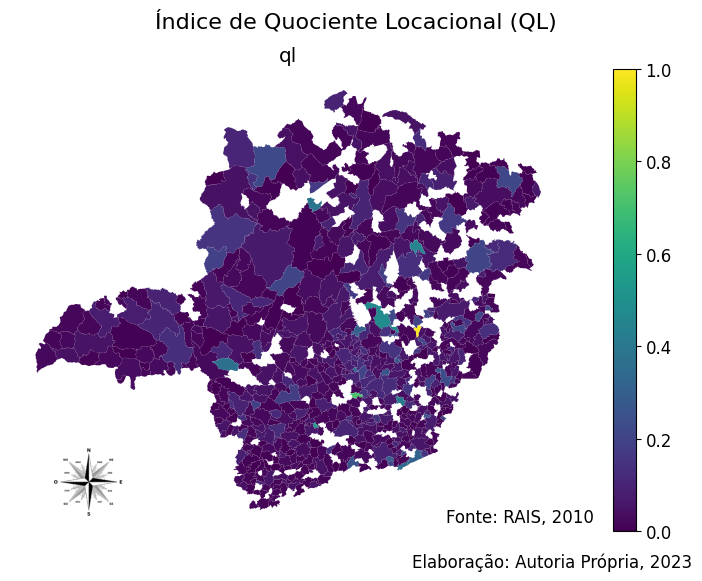

In [103]:
# Seleciona as colunas de interesse
columns = ['ql']

data = df_ql_construcao_2010[columns]

# Normalizar os dados de 0 a 1
data_norm = (data - data.min()) / (data.max() - data.min())

# Criar um novo GeoDataFrame com os dados normalizados e as geometrias dos municípios
data_norm_df = gpd.GeoDataFrame(pd.concat([data_norm, df_ql_construcao_2010['geometry']], axis=1))

# Plotar os mapas para cada coluna
fig, ax = plt.subplots(figsize=(12, 6))

for col in columns:
    data_norm_df.plot(column=col, ax=ax, legend=True, cmap='viridis')
    ax.set_title(col)
    ax.set_facecolor('#f2f2f2')
    ax.axis('off')
    ax.text(1.05, 0.02, 'Fonte: RAIS, 2010', fontsize=12, ha='right', transform=ax.transAxes)
    axins2 = ax.inset_axes([0.065, 0.03, 0.15, 0.15], transform=ax.transAxes)
    axins2.set_aspect('equal')
    axins2.axis('off')
    axins2.imshow(img)

# Adiciona o título
plt.suptitle('Índice de Quociente Locacional (QL)', fontsize=16, x=0.57)

# Adiciona a fonte do gráfico geral
fig.text(0.85, 0.05, 'Elaboração: Autoria Própria, 2023', fontsize=12, ha='right')

# Exibe a plotagem
plt.show()

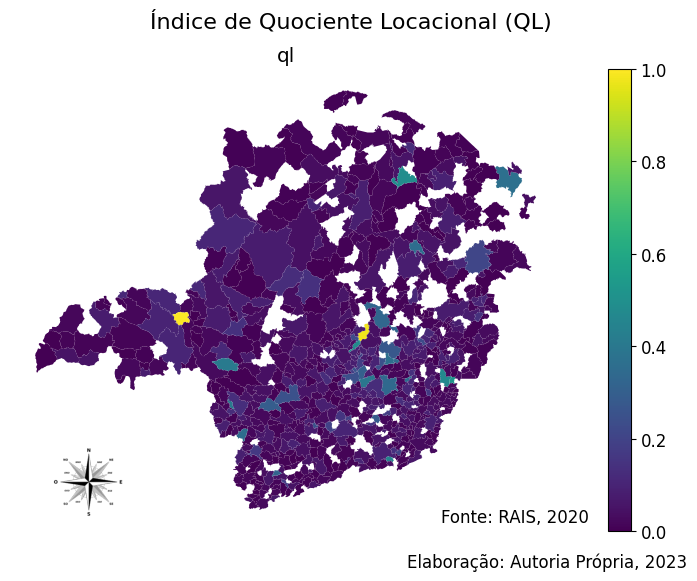

In [104]:
# Seleciona as colunas de interesse
columns = ['ql']

data = df_ql_construcao_2020[columns]

# Normalizar os dados de 0 a 1
data_norm = (data - data.min()) / (data.max() - data.min())

# Criar um novo GeoDataFrame com os dados normalizados e as geometrias dos municípios
data_norm_df = gpd.GeoDataFrame(pd.concat([data_norm, df_ql_construcao_2020['geometry']], axis=1))

# Plotar os mapas para cada coluna
fig, ax = plt.subplots(figsize=(12, 6))

for col in columns:
    data_norm_df.plot(column=col, ax=ax, legend=True, cmap='viridis')
    ax.set_title(col)
    ax.set_facecolor('#f2f2f2')
    ax.axis('off')
    ax.text(1.05, 0.02, 'Fonte: RAIS, 2020', fontsize=12, ha='right', transform=ax.transAxes)
    axins2 = ax.inset_axes([0.065, 0.03, 0.15, 0.15], transform=ax.transAxes)
    axins2.set_aspect('equal')
    axins2.axis('off')
    axins2.imshow(img)

# Adiciona o título
plt.suptitle('Índice de Quociente Locacional (QL)', fontsize=16, x=0.57)

# Adiciona a fonte do gráfico geral
fig.text(0.85, 0.05, 'Elaboração: Autoria Própria, 2023', fontsize=12, ha='right')

# Exibe a plotagem
plt.show()

In [111]:
# Realizar merge externo entre df_ql_construcao_2010 e df_ql_construcao_2020
merged_df = df_ql_construcao_2010.merge(df_ql_construcao_2020, on='id_municipio', how='outer')

# Filtrar os registros ausentes em 2010 (municípios presentes em 2020, mas ausentes em 2010)
municipios_ausentes_2010 = merged_df[merged_df['ql_x'].isnull()]['id_municipio']

# Criar DataFrame com os municípios ausentes em 2010
df_municipios_ausentes_2010 = pd.DataFrame({'id_municipio': municipios_ausentes_2010})

# Realizar merge com geo_mun para obter os nomes dos municípios
df_municipios_ausentes_2010 = df_municipios_ausentes_2010.merge(geo_mun, on='id_municipio', how='left')

# Exibir os municípios ausentes em 2010 com seus nomes
print("Municípios ausentes em 2010 em relação a 2020:")
print(df_municipios_ausentes_2010[['id_municipio', 'NM_MUN']])

Municípios ausentes em 2010 em relação a 2020:
     id_municipio        NM_MUN
0       3100500.0       Açucena
1       3101409.0     Albertina
2       3101805.0     Alpercata
3       3102050.0  Alto Caparaó
4       3102852.0    Angelândia
..            ...           ...
103     3167905.0     Tabuleiro
104     3169109.0        Toledo
105     3170008.0          Ubaí
106     3171402.0       Vieiras
107     3171808.0  Virginópolis

[108 rows x 2 columns]


In [113]:
# Realizar merge externo entre df_ql_construcao_2010 e df_ql_construcao_2020
merged_df = df_ql_construcao_2010.merge(df_ql_construcao_2020, on='id_municipio', how='outer')

# Filtrar os registros ausentes em 2020 (municípios presentes em 2010, mas ausentes em 2020)
municipios_ausentes_2020 = merged_df[merged_df['ql_y'].isnull()]['id_municipio']

# Criar DataFrame com os municípios ausentes em 2020
df_municipios_ausentes_2020 = pd.DataFrame({'id_municipio': municipios_ausentes_2020})

# Realizar merge com df_municipios para obter os nomes dos municípios
df_municipios_ausentes_2020 = df_municipios_ausentes_2020.merge(geo_mun, on='id_municipio', how='left')

# Exibir os municípios ausentes em 2020 com seus nomes
print("Municípios ausentes em 2020 em relação a 2010:")
print(df_municipios_ausentes_2020[['id_municipio', 'NM_MUN']])

Municípios ausentes em 2020 em relação a 2010:
    id_municipio                  NM_MUN
0      3100708.0           Água Comprida
1      3103108.0  Antônio Prado de Minas
2      3104809.0         Augusto de Lima
3      3106804.0             Bias Fortes
4      3107703.0     Bom Jesus do Amparo
..           ...                     ...
82     3170479.0         Uruana de Minas
83     3170529.0                 Urucuia
84     3171105.0               Veríssimo
85     3171154.0           Vermelho Novo
86     3172103.0            Volta Grande

[87 rows x 2 columns]


>  Conteúdo livre

In [114]:
df.to_excel('/content/drive/MyDrive/Colab Notebooks/DataViva/dataviva.xlsx')